<a href="https://colab.research.google.com/github/nihal-rao/deepchem/blob/master/baselines/FREESOLV_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installing DeepChem

In [1]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0  17246      0 --:--:-- --:--:-- --:--:-- 17246


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [2]:
!pip install --pre deepchem
!pip install dgl
!pip install dgllife

     |████████████████████████████████| 552kB 8.5MB/s 
     |████████████████████████████████| 4.3MB 9.1MB/s 
     |████████████████████████████████| 133kB 9.1MB/s 
  Created wheel for dgllife: filename=dgllife-0.2.6-cp37-none-any.whl size=205837 sha256=966ec5eb90572d47aaee3986a5715ca2a6e9a7acaf0facd979f5b7a28a6e78fb
  Stored in directory: /root/.cache/pip/wheels/cf/29/39/54bbf37c8999f605d347805d4dec838e9ca8a894c90b119600
Successfully built dgllife


In [3]:
import deepchem as dc
dc.__version__

'2.6.0.dev'

## Using GraphConv featuriser

Implementing and recording the baseline for Tox21 dataset.

In [5]:
featurizer = dc.feat.MolGraphConvFeaturizer()
tasks, datasets, transformers = dc.molnet.load_sampl(featurizer=featurizer)
train_dataset, valid_dataset, test_dataset = datasets
print(train_dataset)

<DiskDataset X.shape: (511,), y.shape: (511, 1), w.shape: (511, 1), ids: ['CS(=O)(=O)Cl' 'CC(C)C=C' 'CCCCCCCO' ... 'CC1=CCCCC1'
 'CC1=CC[C@H](C[C@@H]1O)C(=C)C' 'CC(=C)[C@H]1CCC(=CC1)C=O'], task_names: ['expt']>


`MolGraphConvFeaturizer` class is a featurizer of general graph convolution networks for molecules.

The default node(atom) and edge(bond) representations are based on WeaveNet paper.

The default node representation are constructed by concatenating the following values, and the feature length is 30.

    Atom type: A one-hot vector of this atom, “C”, “N”, “O”, “F”, “P”, “S”, “Cl”, “Br”, “I”, “other atoms”.

    Formal charge: Integer electronic charge.

    Hybridization: A one-hot vector of “sp”, “sp2”, “sp3”.

    Hydrogen bonding: A one-hot vector of whether this atom is a hydrogen bond donor or acceptor.

    Aromatic: A one-hot vector of whether the atom belongs to an aromatic ring.

    Degree: A one-hot vector of the degree (0-5) of this atom.

    Number of Hydrogens: A one-hot vector of the number of hydrogens (0-4) that this atom connected.

    Chirality: A one-hot vector of the chirality, “R” or “S”. (Optional)

    Partial charge: Calculated partial charge. (Optional)

The default edge representation are constructed by concatenating the following values, and the feature length is 11.

    Bond type: A one-hot vector of the bond type, “single”, “double”, “triple”, or “aromatic”.

    Same ring: A one-hot vector of whether the atoms in the pair are in the same ring.

    Conjugated: A one-hot vector of whether this bond is conjugated or not.

    Stereo: A one-hot vector of the stereo configuration of a bond.


In [ ]:
tasks

['expt']

The task corresponds to predicting the free hydration energy in kcal/mol for a given molecule.

In [ ]:
datasets

(<DiskDataset X.shape: (511,), y.shape: (511, 1), w.shape: (511, 1), ids: ['CS(=O)(=O)Cl' 'CC(C)C=C' 'CCCCCCCO' ... 'CC1=CCCCC1'
  'CC1=CC[C@H](C[C@@H]1O)C(=C)C' 'CC(=C)[C@H]1CCC(=CC1)C=O'], task_names: ['expt']>,
 <DiskDataset X.shape: (64,), y.shape: (64, 1), w.shape: (64, 1), ids: ['c1ccc2cc(ccc2c1)O' 'Cc1ccc2cc(ccc2c1)C' 'c1ccc2ccccc2c1' ...
  'c1cnc[nH]1' 'Cn1ccnc1' 'Cc1c[nH]cn1'], task_names: ['expt']>,
 <DiskDataset X.shape: (64,), y.shape: (64, 1), w.shape: (64, 1), ids: ['CN1CCNCC1' 'CN1CCN(CC1)C' 'C1CNCCN1' ... 'Cc1cccc(c1C)Nc2ccccc2C(=O)O'
  'C1CCCC(CC1)O' 'c1ccc2c(c1)CCC2'], task_names: ['expt']>)

There are three dataset objects - train split, val split and test split. Each split consists of X and y - X is the features and y is the output label. Froe example the train split has X.shape (513, 1024)
and y.shape (513, 1). This implies that there are 513 samples in the train split - and each sample is represented by an ECFP vector of size 1024. 

##GCN Model

In [ ]:
from deepchem.models import GCNModel
model = GCNModel(mode='regression', n_tasks=len(tasks), batch_size=32, learning_rate=0.001)
model.fit(train_dataset, nb_epoch=15)

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


0.08678099513053894

`GCNModel` is a self-written modification of the GraphConv model with improved regularisation. It uses a different method of computing graph-level representations, computing a weighted sum and an element-wise maximum of the representations of all nodes in a graph and concatenates them. The node weights are obtained by using a linear/dense layer followed by a sigmoid function. 
For each graph convolution, the learnable weight in this model is shared across all nodes. 
There are also minor differences in using dropout, skip connections and batch normalization. 

In [ ]:
import numpy as np

metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('training set score:', model.evaluate(train_dataset, [metric], transformers))
print('test set score:', model.evaluate(test_dataset, [metric], transformers))

training set score: {'pearson_r2_score': 0.9431421065989187}
test set score: {'pearson_r2_score': 0.6446763783350966}


##Prediction Demo

In [6]:
print(test_dataset.ids[0])

CN1CCNCC1


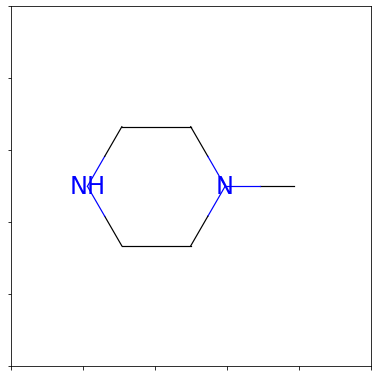

In [10]:
from rdkit import Chem
from rdkit.Chem import Draw

import matplotlib.pyplot as plt
%matplotlib inline

smiles_to_mol = Chem.MolFromSmiles(test_dataset.ids[0])

g = Draw.MolToMPL(smiles_to_mol, size=(200, 200))

In [ ]:
print(test_dataset.y[0])
model.predict(test_dataset)[0]

[-1.37468584]


array([-1.5586928], dtype=float32)